In [1]:
import dowhy
import pandas as pd
import dowhy.plotter as plotter

In [2]:
df = pd.read_csv('data/all_types.csv')

In [3]:
df.head()

,Age,Gender,Race,Length of Hospital Stay (LOS),Height_cm,Weight-kg,BMI,sPESI,PESI Class,PE Severity 1=low risk; 2=intermediate; 3=massive; 4=indeterminate,...,Platelet <70k,Etiology of Clot,adverseEvent,type,Required supplemental O2,"Acute DVT (deep venous thrombosis), 3 = chronic",Elevated Initial Troponin,RV/LV Ratio .85 to .90,RV/LV Ratio .91-.94,RV/LV Ratio .95 or greater
0,72,M,W,3,175.3,83.5,27.2,0,2,1,...,0.0,trauma,0,saddle,NaN,NaN,NaN,NaN,NaN,NaN
1,74,F,W,3,170.2,76.3,26.3,0,2,2,...,0.0,surgery,0,saddle,NaN,NaN,NaN,NaN,NaN,NaN
2,57,F,B,3,152.4,97.1,41.8,0,2,1,...,0.0,trauma,0,saddle,NaN,NaN,NaN,NaN,NaN,NaN
3,64,M,W,3,175.3,72.2,23.5,0,2,2,...,0.0,immobility- car travel,0,saddle,NaN,NaN,NaN,NaN,NaN,NaN
4,68,M,B,8,152.4,80.3,34.6,1,5,2,...,0.0,personal history,0,saddle,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Rename Column
df = df.rename(columns={'PE Severity 1=low risk; 2=intermediate; 3=massive; 4=indeterminate':'severity'})
# Convert to binary, non-text treatment
df.type = df.type.map({'saddle':1, 'non-saddle':0})

In [5]:
# df.type = df.type.astype('category')
df.type.value_counts()

1    180
0    158
Name: type, dtype: int64

## Create Model

In [6]:
# Define Causal Model (Identification Step, generated from Dagitty)
dot_graph = 'digraph {"severity" [pos="-0.555,0.994"];Age [pos="-2.194,-1.444"];BMI [pos="-0.506,0.290"];Gender [pos="-0.617,-1.305"];Race [pos="0.725,-1.292"];adverseEvent [outcome,pos="1.400,1.621"];type [exposure,pos="-2.200,1.597"];"severity" -> adverseEvent;"severity" -> type;Age -> "severity";Age -> BMI [pos="-0.791,-1.045"];Age -> adverseEvent;Age -> type;BMI -> "severity";BMI -> adverseEvent;BMI -> type;Gender -> BMI [pos="0.680,-0.496"];Gender -> adverseEvent;Gender -> type;Race -> "severity";Race -> BMI;Race -> adverseEvent;Race -> type;type -> adverseEvent}'

dot_graph_test = 'digraph {Gender [pos="-0.617,-1.305"];adverseEvent [outcome,pos="1.400,1.621"];type [exposure,pos="-2.200,1.597"];Gender -> adverseEvent;Gender -> type;type -> adverseEvent}'

In [7]:
causal_model = dowhy.CausalModel(data=df, treatment='type', outcome='adverseEvent', graph=dot_graph)

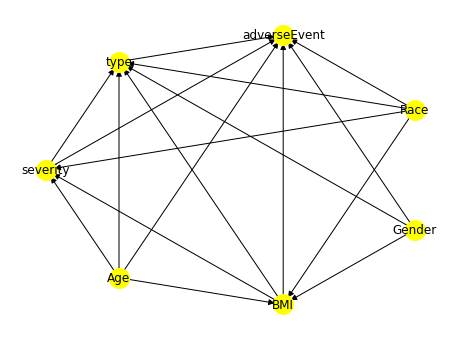

In [8]:
causal_model.view_model()

## Identification

In [9]:
identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                 
───────(E[adverseEvent|severity,Race,Gender,BMI,Age])
d[type]                                              
Estimand assumption 1, Unconfoundedness: If U→{type} and U→adverseEvent then P(adverseEvent|type,severity,Race,Gender,BMI,Age,U) = P(adverseEvent|type,severity,Race,Gender,BMI,Age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimation of ATE

In [18]:
causal_estimate = causal_model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", confidence_intervals=True)
print(causal_estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                 
───────(E[adverseEvent|severity,Race,Gender,BMI,Age])
d[type]                                              
Estimand assumption 1, Unconfoundedness: If U→{type} and U→adverseEvent then P(adverseEvent|type,severity,Race,Gender,BMI,Age,U) = P(adverseEvent|type,severity,Race,Gender,BMI,Age)

## Realized estimand
b: adverseEvent~type+severity+Race+Gender+BMI+Age
Target units: ate

## Estimate
Mean value: 0.026022048106369197
95.0% confidence interval: [[-0.0346067   0.08665079]]



Interval for ATE crosses zero, showing that type does not have a causal effect on adverse event rates

In [17]:
# Plot Slope of line between treamtent and outcome =causal effect
# plotter.plot_causal_effect(causal_estimate, df['type'], df['adverseEvent'])
# help(plotter.plot_causal_effect)

## Refutations

Test the model to see if we can invalidate the results within different artificial scenarios

In [13]:
# Add random common cause variable
res_random=causal_model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
print(res_random)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

In [15]:
# Replace treatment with random placebo 
res_placebo=causal_model.refute_estimate(identified_estimand, causal_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

In [16]:
# Remove random subset of data
res_subset=causal_model.refute_estimate(identified_estimand, causal_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effe

After simple refutations, our model proves robust.

The results of this analysis confirm the results found in the previous PE Study analysis found here: https://carlosbrown2.github.io/pe-study/study.html

Submassive PE type is not a cause of differences in adverse event rates for inpatients. Patients with Saddle type PE are no more likely to experience adverse events than are non-Saddle type PE patients.